---
title: Scientific machine learning with DeepPumas
execute:
  error: false
  cache: true
author:
  - Niklas Korsbo
affiliation: Pumas-AI
  
date: 2024-04-17
julia:
  exeflags:
    - '--project=..'
logo: 'https://pumas-assets.s3.amazonaws.com/CompanyLogos/DeepPumas/RGB/SVG/DeepPumas+Primaryv.svg'
format:
  revealjs:
    width: 1200
    height: 800
    auto-stretch: false
    html-math-method: mathjax
    transition: none
    center: true
    scrollable: false
    progress: true
    slide-number: true
    smaller: false
    theme: custom_moon.scss
    # theme: solarized
    navigation-mode: vertical
    css: style.css
    mermaid:
      theme: dark
      flowchart:
        htmlLabels: true
    fig-align: center
engine: julia 
---

# Introduction

```{=html}
<style>
.MathJax {
    font-size: 80% !important;
}
</style>
```

In [3]:
using Pkg
Pkg.activate(@__DIR__() * "/../")

  Activating project at `~/projects/workshops/DeepPumas_workshop_2024_BI`


In [29]:
#| warning: false
#| output: false
using DeepPumas
using StableRNGs
using PumasPlots
using CairoMakie
using Serialization
using Latexify
using Markdown
using QuartoTools: @cache

dark = true
if dark
  set_theme!(deep_dark(); backgroundcolor=:transparent, fontsize=45)
  fgcolor = (:white, 0.6)
else
  set_theme!(deep_light();backgroundcolor=:transparent, fontsize=45, Axis=(; 
    backgroundcolor=:transparent,
    # foregroundcolor=:black
  ))
  fgcolor = (:black, 0.7)
end

figure = (; resolution=(1200, 700), fontsize=25)

Latexify.set_default(starred=true, convert_unicode=false)

##


![&nbsp;](image.png){width=50% align="center"}


:::: {.columns style="font-size: 70%"}
::: {.column width=0.4}
Machine learning

::: {.callout-tip appearance="minimal"}
- Data-driven model discovery
- Finds unintuitive relationships
- Handles complex data
:::

::: {.callout-important appearance="minimal"}
- Lacks scientific understanding
- Requires big data
- Inscrutible  
:::
:::
  

::: {.column width=0.4}
Scientific modelling

::: {.callout-tip appearance="minimal"}
- Encodes scientific understanding
- Data-efficient
- Interpretable
- Simple counterfactuals
:::

::: {.callout-important appearance="minimal"}
- Labor intensive
- Misses unintuitive relationships
- Hard to utilize complex data
:::
:::
::::
  

## {.center}
![](image-3.png)

##

![](image-6.png)

##

![&nbsp;](image-7.png){width=70%}

##

![&nbsp;](image-1.png){width=70%}

In [5]:
#| output: false
pkmodel = @model begin
  @param begin
    tvKa in RealDomain(; lower=0)
    tvCL in RealDomain(; lower=0)
    tvVc in RealDomain(; lower=0)
    Ω in PDiagDomain(3)
    σ in RealDomain(; lower=0)
  end
  @random η ~ MvNormal(Ω)
  @pre begin
    Ka = tvKa * exp(η[1])
    CL = tvCL * exp(η[2])
    Vc = tvVc * exp(η[3])
  end
  @dynamics Depots1Central1
  @derived Concentration ~ @. Normal(Central/Vc, Central/Vc * σ)
end

param = (; tvKa = 2., tvCL=3., tvVc=1., Ω = [0.5, 0.5, 0.5], σ=0.1)
rng = StableRNG(1)
sims = map(1:20) do i 
  _subj = Subject(; id=i, events = DosageRegimen(1, ii=1, addl=2))
  sim = simobs(pkmodel, _subj, param; rng, obstimes = 0:0.2:4)
end
pop = Subject.(sims)

Population
  Subjects: 20
  Observations: Concentration

## {.smaller}

:::: {.columns}

::: {.column width="50%"}

**[Nonlinear Mixed Effects]{.att}**

::: {.fragment fragment-index=3 .fade-out}
::: {.absolute top=300, right=10, width=600}

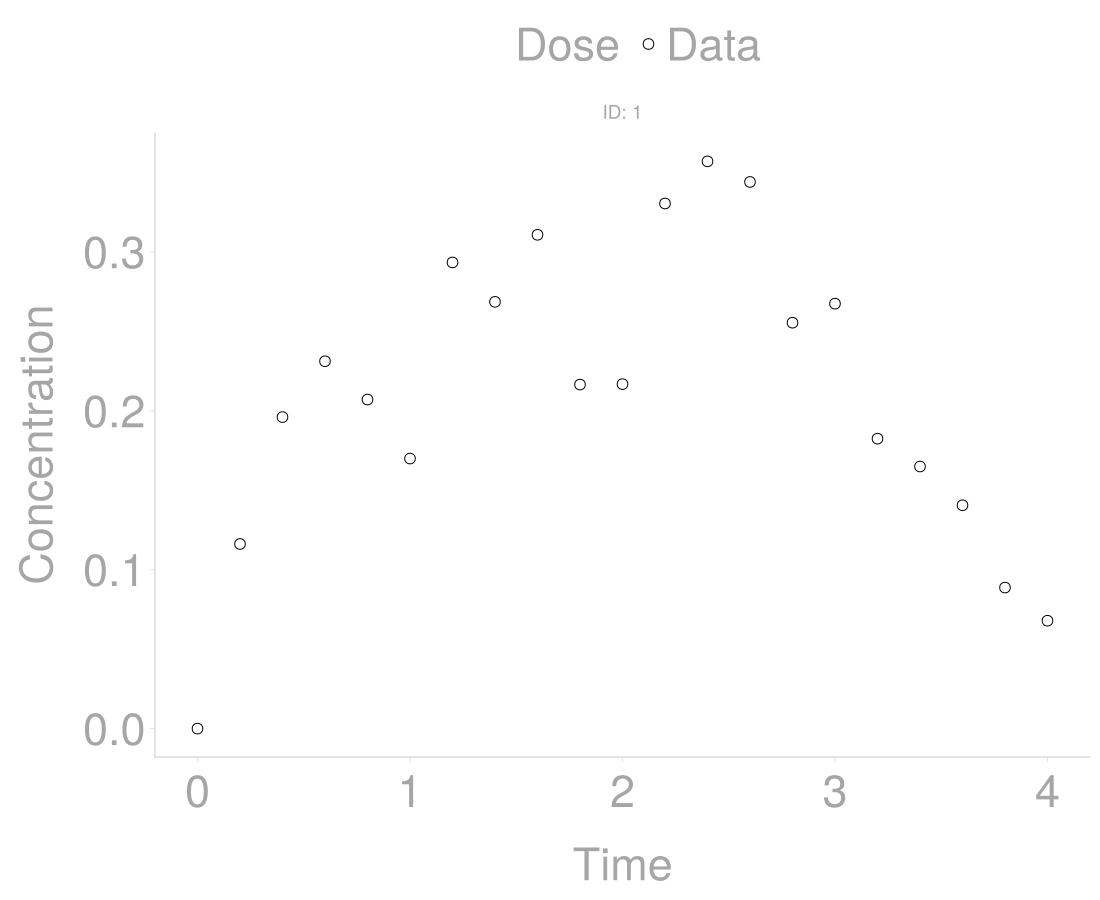

In [6]:
sim = (; label="Data", markersize=15, linewidth=1, color=fgcolor)
plt = plotgrid(sims[1:1]; sim)

:::
:::

::: {.fragment fragment-index=3}

::: {.absolute top=500, right=100, width="600"}

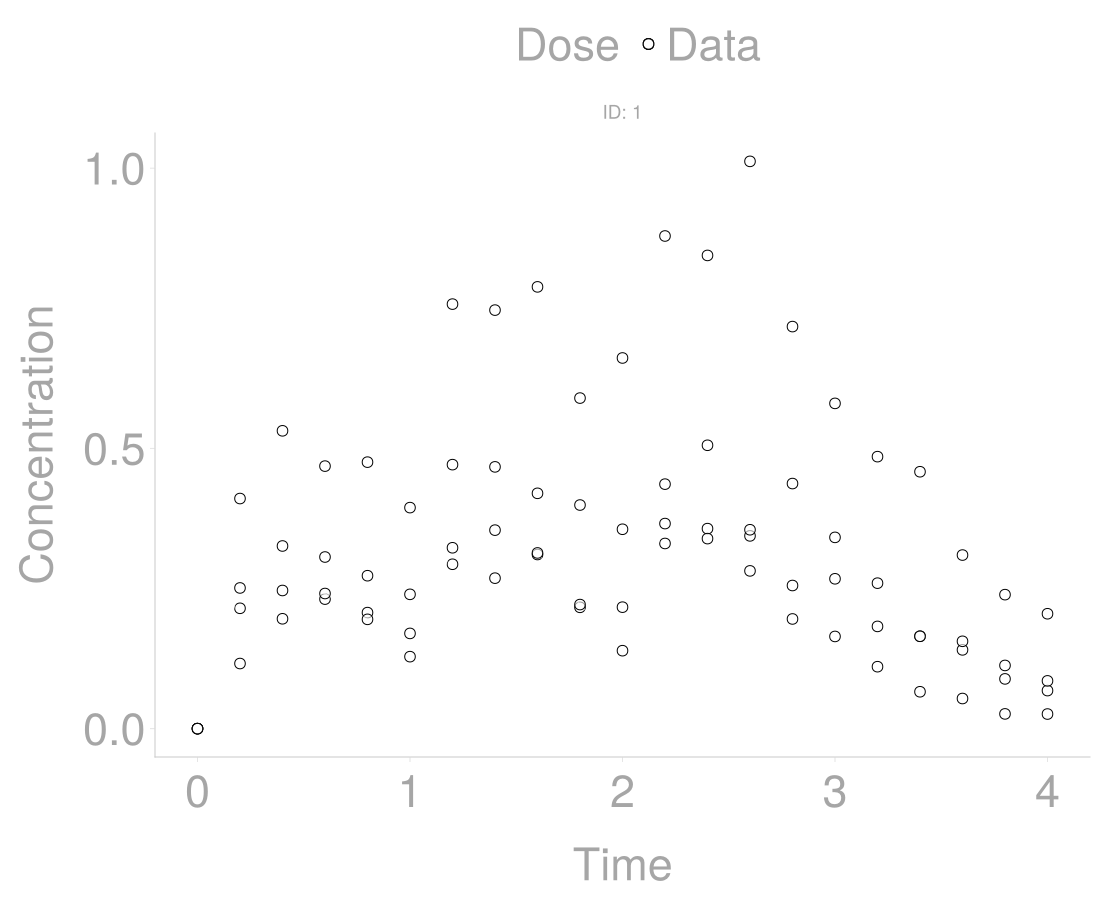

In [7]:
foreach(sims[2:4]) do _sim
  plotgrid!(plt, [_sim]; sim)
end
plt

:::
:::

:::

::: {.column width="50%"}


::: {.fragment fragment-index=5}
Typical values

$$
tvKa, \; tvCL, \; tvVc, \; Ω, \; σ
$$

Covariates
$$
Age, \; Weight
$$

Random effects

$$
η \sim MvNormal(Ω)
$$

:::
  
::: {.fragment fragment-index=4}
Individual parameters

\begin{align*}
Ka_i &= tvKa \cdot e^{η_{i,1}} \\
CL_i &= tvCL \cdot e^{η_{i,2}} \\
Vc_i &= tvVc \cdot e^{η_{i,3}}
\end{align*}
:::

::: {.fragment fragment-index=1}
Dynamics

In [11]:
#| output: asis
latexify(pkmodel, :dynamics)

L"\begin{align*}
\frac{dDepot(t)}{dt} =& \left(  - Ka \right) \cdot Depot(t) \\
\frac{dCentral(t)}{dt} =& Ka \cdot Depot(t) - \frac{CL}{Vc} \cdot Central(t)
\end{align*}
"

:::
::: {.fragment fragment-index=2}
Error model
$$
Concentration(t) \sim Normal\left(\frac{Central(t)}{Vc}, \frac{Central(t)}{Vc} \cdot σ\right)
$$
:::




:::
::::

---

In [8]:
#| output: false
using Flux
using CairoMakie
using Colors

ninput = 1
nhidden = 6
act=tanh

opt = Adam()
X = permutedims(collect(range(0, stop=1, length=301)))
Ys = [X .^ 2 .+ X, 2 .* X ./ (0.3 .+ X), sin.(2π .* X) .+ 1, exp2.(X)]

##
nnf = Flux.Chain(Dense(1,nhidden, act), Dense(nhidden, nhidden, act), Dense(nhidden, 1))
Ŷ = Observable(vec(Ys[end]))
Y = Observable(vec(Ys[1]))

fig, ax = lines(vec(X), Y; linewidth=6, axis=(ylabel="Output", xlabel="x"), label="f(x)", figure=(; resolution=(400,400), fontsize=25, backgroundcolor=colorant"#002b36"))
lines!(vec(X), Ŷ, label="NN(x)", linewidth=6)
Legend(fig[0,:], ax, orientation=:horizontal, framevisible=false)
fig
Ys = [X .^ 2 .+ X, 2 .* X ./ (0.3 .+ X), sin.(2π .* X) .+ 1, exp2.(X)]
nframes = 400
opt_state = Flux.setup(opt, nnf)
record(fig, "nn_demo_test.mp4", 1:nframes; framerate=30) do frame
  _Y = Ys[min(round(Int, frame ÷ (nframes/length(Ys))) + 1, end)]
  Y[] = vec(_Y)
  Ŷ[] = vec(nnf(X))
  
  steps_per_y = nframes / length(Ys)
  
  for j in 1:round(Int, 50 / steps_per_y * (frame%steps_per_y))
  grads = gradient(m -> Flux.mse(m(X), _Y), nnf)
    Flux.Optimise.update!(opt_state, nnf, grads[1])
  end
end 

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(1 => 6, tanh)
│   summary(x) = 1×301 Matrix{Float64}
└ @ Flux /Users/niklas/.julia/packages/Flux/ljuc2/src/layers/stateless.jl:60


"nn_demo_test.mp4"

## Neural networks {.smaller}

:::: {.columns}
::: {.column width="50%"}

[Information processing mechanism]{.att}

- Loosely based on neurons

![&nbsp;](image-4.png){fig-align="center"}

- Mathematically just a function!
- Usable anywhere you'd use a function!

:::
::: {.column width="50%"}

[Univeral approximators!]{.att}

![](nn_demo_test.mp4){loop="true" autoplay="true" muted="true"}

- Approximate *any* function
- Functional form tuned by parameters

:::
::::

## {.smaller}

:::: {.columns}

::: {.column width="50%"}

**[Deep Nonlinear Mixed Effects]{.att}**

::: {.absolute top=500, right=100, width="600"}

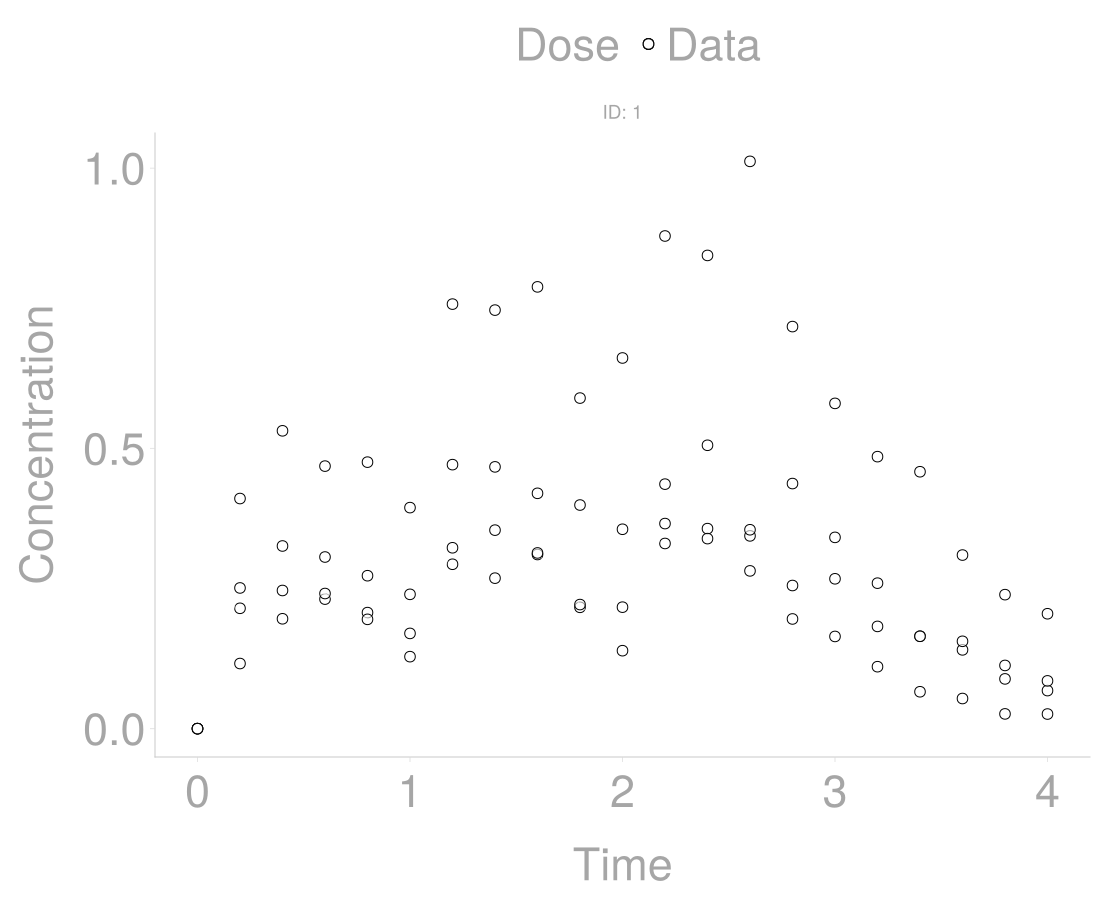

In [9]:
plt

:::
:::

::: {.column width="50%"}


Typical values

$$
tvKa, \; tvCL, \; tvVc, \; Ω, \; σ
$$

Covariates
$$
Age, \; Weight
$$

Random effects

$$
η \sim MvNormal(Ω)
$$

  
Individual parameters

\begin{align*}
Ka_i &= tvKa \cdot e^{η_{i,1}} \\
CL_i &= tvCL \cdot e^{η_{i,2}} \\
Vc_i &= tvVc \cdot e^{η_{i,3}}
\end{align*}

::: {.fragment}
![](image-8.png){.absolute top=150 right=90 width=110}
:::
::: {.fragment}
![](image-4.png){.absolute top=380 right=90 width=100}
:::
::: {.fragment}
![](image-4.png){.absolute bottom=140 right=80 width=130}
:::

Dynamics

In [10]:
latexify(pkmodel, :dynamics)

L"\begin{align*}
\frac{dDepot(t)}{dt} =& \left(  - Ka \right) \cdot Depot(t) \\
\frac{dCentral(t)}{dt} =& Ka \cdot Depot(t) - \frac{CL}{Vc} \cdot Central(t)
\end{align*}
"

Error model
$$
Concentration(t) \sim Normal\left(\frac{Central(t)}{Vc}, \frac{Central(t)}{Vc} \cdot σ\right)
$$



:::
::::

## Ok, all good? Crystal clear? That was a short!

::: {.fragment}
Well...

- What's this business of combining differential equations and ML?
- What does random effects do and how do we train such a model?
- How does random effects interact with machine learning?
:::


# Neural-embedded dynamical systems {.smaller}

## Neural-embedded dynamical systems {.smaller}

2018 - "Neural Ordinary Differential Equations", Chen et al.

::: {.fragment fragment-index=1}
2020 - "Universal Differential Equations for Scientific Machine Learning", Rackauckas et al.
:::

:::: {.columns}
::: {.column width="33%"}

[Neural ODE]{.att}

$$
\frac{d\mathbf{X}}{dt} = NN(\mathbf{X}(t), t)
$$

::: {style="font-size: 80%"}
ODE solver as scaffold for neural networks

Similar to recurrent neural networks and ResNets

:::
:::
::: {.column width="33%"}

::: {.fragment fragment-index=1}
[Universal Differential Equations (UDE)]{.att}

\begin{align*}
\frac{dx}{dt} &= x \cdot y - NN(x)\\
\frac{dy}{dt} &= p - x \cdot y
\end{align*}

::: {style="font-size: 80%"}
Insert universal approximators (like NNs) to capture terms in dynamical systems. 
:::
:::

:::
::: {.column width="33%"}
::: {.fragment fragment-index=2}

[Scientific Machine Learning (SciML)]{.att}

::: {style="font-size: 80%"}
An abstract concept of mixing scientific modeling with machine learning. 
:::

:::
:::
::::

## Encoded knowledge {.smaller}

:::: {.columns}

::: {.column width="50%"}

[
$$
\begin{aligned}
\frac{dDepot}{dt} &= NN(Depot, Central, R)[1]\\
\frac{dCentral}{dt} &= NN(Depot, Central, R)[2]\\
\frac{dR}{dt} &= NN(Depot, Central, R)[3]
\end{aligned}
$$
]{.att}

- Number of states

::: {.fragment}

[
$$
\begin{aligned}
\frac{dDepot}{dt} &= - NN_1(Depot)\\
\frac{dCentral}{dt} &= NN_1(Depot) - NN_2(Central)\\
\frac{dR}{dt} &= NN_3(Central, R)
\end{aligned}
$$
]{.att}

- Number of states
- Dependecies
- Conservation

:::
:::

::: {.column width="50%"}

::: {.fragment}

[
$$
\begin{aligned}
\frac{dDepot}{dt} &= - K_a \cdot Depot\\
\frac{dCentral}{dt} &= K_a \cdot Depot - CL/V_c \cdot Central\\
\frac{dR}{dt} &= NN_3(Central, R)
\end{aligned}
$$
]{.att}

- Explicit knowledge of some terms

:::
  
::: {.fragment}
[
$$
\begin{aligned}
\frac{dDepot}{dt} &= - K_a \cdot Depot\\
\frac{dCentral}{dt} &= K_a \cdot Depot - CL/V_c \cdot Central\\
\frac{dR}{dt} &= k_{in} \cdot (1 + NN(Central)) - k_{out} \cdot R
\end{aligned}
$$
]{.att}

- Precise position of the unknown function
- Precise input to the unknown input
- Lots of knowledge!

:::
:::


::::

## UDEs - pretty simple, really {.smaller}


![
Mathematically: just a function!
](image-4.png){fig-width="40%" fig-cap-alignment="center"}


NNs useable anywhere you'd use a function!

- Decide where in the dynamics you have an unknown function.
- Decide what inputs this function may have.
- Fit [everything]{.underline} in concert

The only hard part is building software for robust fitting - but we've got you covered there!


# Mixed effects

## Why mixed effects?

Handle heirarchy of data variability!

Distinguish commonalities from differences

- Population data $\to$ Patient $\to$ Repeated observations
- Global data $\to$ Country $\to$ Infected over time
- Hospital data $\to$ Doctor $\to$ patient outcomes


::: {style="text-align:center"}
![Gaze estimation ^[Xiong et al., 2019, Mixed Effect Neural Networks (MeNets) with Applications to Gaze Estimation]](image-9.png){width="50%"}
:::



## Simulating with random effects


:::: {.columns}
::: {.column width="50%"}
- [Sample]{.att} from the prior distribution
- Use as any ["normal" value]{.att}.
- Simple!
:::

::: {.column width="50%"}


Typical values

$$
tvKa, \; tvCL, \; tvVc, \; Ω, \; σ
$$

Covariates
$$
Age, \; Weight
$$

Random effects

$$
η \sim {\textcolor{orange}{MvNormal(Ω)}}
$$

  
Individual parameters

\begin{align*}
Ka_i &= tvKa \cdot e^{\textcolor{orange}{η_{i,1}}} \\
CL_i &= tvCL \cdot e^{\textcolor{orange}{η_{i,2}}} \\
Vc_i &= tvVc \cdot e^{\textcolor{orange}{η_{i,3}}}
\end{align*}

Dynamics

In [ ]:
latexify(pkmodel, :dynamics)

L"\begin{align*}
\frac{dDepot(t)}{dt} =& \left(  - Ka \right) \cdot Depot(t) \\
\frac{dCentral(t)}{dt} =& Ka \cdot Depot(t) - \frac{CL}{Vc} \cdot Central(t)
\end{align*}
"

Error model
$$
Concentration(t) \sim Normal\left(\frac{Central(t)}{Vc}, \frac{Central(t)}{Vc} \cdot σ\right)
$$
:::
::::


## Fitting with random effects

[Joint likelihood]{.att} / maximum aposteriori

&nbsp;

Find fixed effects, θ and random effects, η that, given covariates x, and Data, maximize the likelihood $L$.

[
$$
\textcolor{orange}{L(θ, η | Data, x)} \cdot P(\eta | \theta)
$$
]{style="font-size=180%"}

Maximizes the conditional probability that the data comes from the model $P(Data | θ, η, x)$.

Essentially minimises a distance between predicted and observed values.

## Fitting with random effects
[Their effect is largely determined by how they contribute to the loss function of a model fit]{style="font-size: 60%"}

[Marginal likelihood]{.att}

Maginalize the random effects, weighted by its prior.

[
$$
L_m(θ | Data, x) = \int L(θ, η | Data, x) P(η | θ) dη
$$
]{.att}

Maximizes the weighted average probability for all possible random effect values. 

Penalizes sensitivity to the precise random effect values.

## Fitting with random effects

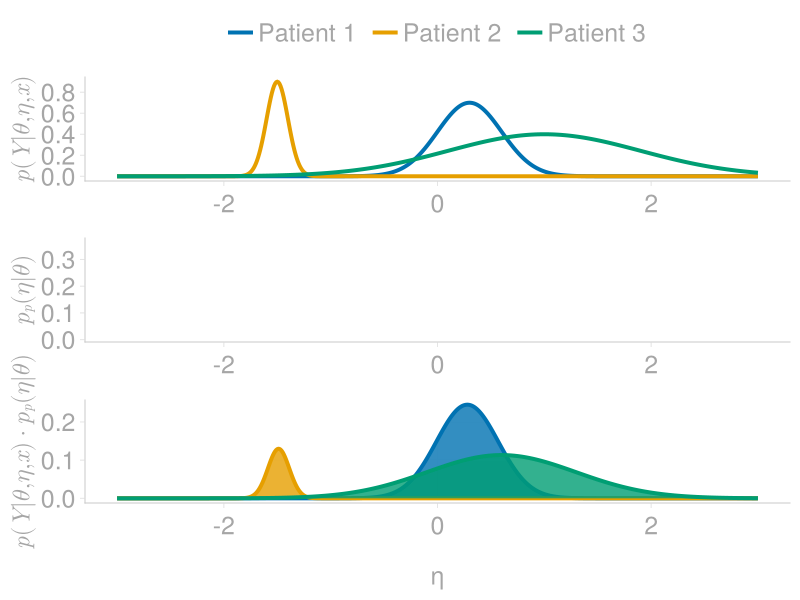

In [12]:
#| fig-cap: '&nbsp;'

f(x; s=1, μ=0, σ=1) = @. s * exp(- (x-μ)^2/(2σ^2)) 
p(x; σ = 1.1) = f(x; σ, s=1/(σ*sqrt(2π)))

x = -3:0.01:3

fig = Figure(; size=(1200, 1200), fontsize=25)
ylabels=[L"p(Y|θ,η,x)", L"p_{p}(η|θ)", L"p(Y|θ,η,x) \cdot p_{p}(η|θ)"]
axes = [Axis(fig[i,1], ylabel=ylabels[i]) for i in 1:3]
_l1 = lines!(axes[1], x, f(x; s=0.7, μ=0.3, σ=0.3))
_l2 = lines!(axes[1], x, f(x; s=0.9, μ=-1.5, σ=0.1))
_l3 = lines!(axes[1], x, f(x; s=0.4, μ=1., σ=0.9))

lines!(axes[2], x, p(x), color=fgcolor)

lines!(axes[3], x, p(x) .* f(x; s=0.7, μ=0.3, σ=0.3))
band!(axes[3], x, 0, p(x) .* f(x; s=0.7, μ=0.3, σ=0.3))
lines!(axes[3], x, p(x) .* f(x; s=0.9, μ=-1.5, σ=0.1))
band!(axes[3], x, 0, p(x) .* f(x; s=0.9, μ=-1.5, σ=0.1), alpha=0.1)
lines!(axes[3], x, p(x) .* f(x; s=0.4, μ=1., σ=0.9))
band!(axes[3], x, 0, p(x) .* f(x; s=0.4, μ=1., σ=0.9), alpha=0.4)
Label(fig[end+1, :], "η", tellwidth=false)
Legend(fig[0,:], [_l1, _l2, _l3], ["Patient 1", "Patient 2", "Patient 3"], tellwidth=false, orientation=:horizontal)
fig

## Marginal likelihood in reality

$$
L_m(θ | Data, x) = \int L(θ, η | Data, x) P(η | θ) dη
$$

Often intractable.

Direct approximate maximization

- Laplace, FOCE, FO

Indirect maximization

- Expectation maximization (EM)
  - Stochastic appromimation (SAEM)
  - Variational inference (VIEM)


## ~~Mixed effect~~ neural networks {.animated data-transition="fade-in fade-out"}

┌ Info: Checking the initial parameter values.
└ @ Pumas /Users/niklas/.julia/packages/Pumas/PkWZl/src/estimation/likelihoods.jl:4092
┌ Info: The initial negative log likelihood and its gradient are finite. Check passed.
└ @ Pumas /Users/niklas/.julia/packages/Pumas/PkWZl/src/estimation/likelihoods.jl:4111


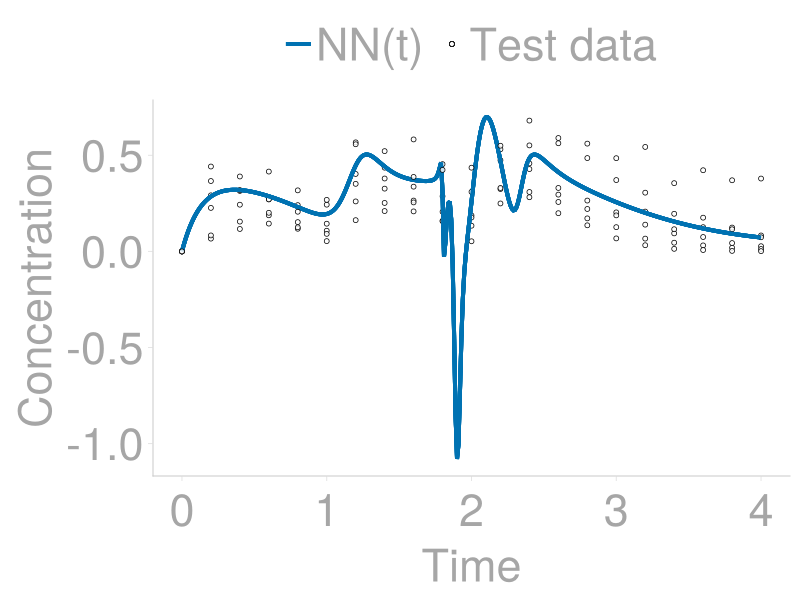

In [15]:
#| fig-cap: "&nbsp;"
direct_time = @model begin
  @param begin
    NN ∈ MLPDomain(1, 7, 7, (1, identity); reg=L2())
    σ ∈ RealDomain(; lower=0)
  end
  @derived Concentration ~ @. Normal(first(NN(t)), σ)
end
pop_nodose = Subject.(pop; events=nothing)
fpm_time = fit(
  direct_time,
  pop_nodose[1:14],
  init_params(direct_time),
  NaivePooled();
  optim_options=(;iterations=1000, show_trace=false)
)
pred = predict(fpm_time, pop_nodose[15:end]; obstimes=0:0.01:4)

fig = Figure(; figure = (; size = (1000,600), fontsize=25))
ax1 = Axis(fig[1,1]; ylabel = "Concentration", xlabel="Time")
for (i, p) in enumerate(pred)
  plotgrid!([ax1], [p]; data = (; label="Test data"), title=false, ipred=false, pred = (; label="NN(t)"))
end
Legend(fig[0,:], ax1; merge=true, orientation=:horizontal, tellwidth=false)

fig


## ~~Mixed effect~~ neural networks {.animated data-transition="fade-in fade-out"}

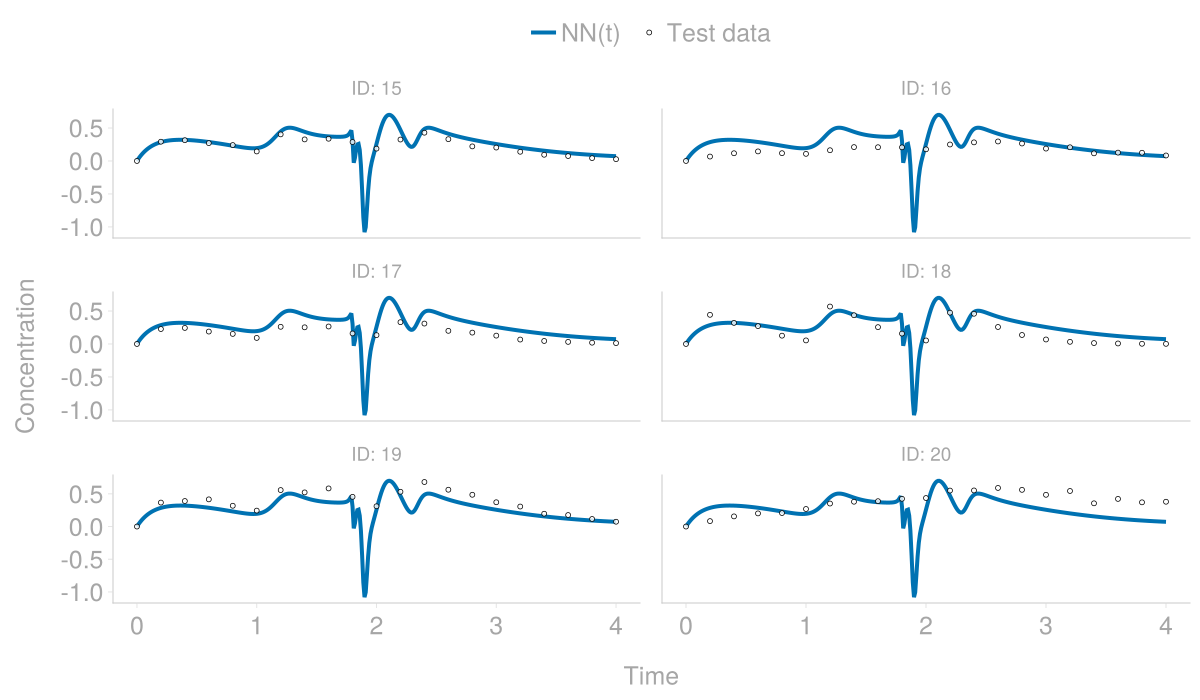

In [16]:
#| fig-cap: "&nbsp;"

pred = predict(fpm_time, pop_nodose[15:end]; obstimes=0:0.01:4)

plotgrid(pred; ipred=false, pred=(; label="NN(t)"), data=(; label="Test data"), figure) 


## Mixed effect neural networks {.animated data-transition="fade-in fade-out"}

In [31]:
#| warning: false
#| output: false

menet = @model begin
  @param begin
    NN ∈ MLPDomain(3, 7, 7, (1, identity); reg=L2())
    σ ∈ RealDomain(; lower=0)
  end
  @random η ~ MvNormal(2, 0.1)
  @derived Concentration ~ map(t) do _t
    Normal(NN(_t, η)[1], σ)
  end
end
pop_nodose = Subject.(pop; events=nothing)
fpm = @cache fit(
  menet,
  pop_nodose[1:14],
  init_params(menet),
  MAP(FOCE()); 
  optim_options=(;iterations=1000, show_trace=false)
)


FittedPumasModel

Successful minimization:                     false

Likelihood approximation:               MAP (FOCE)
Likelihood Optimizer:                         BFGS
Dynamical system type:          No dynamical model

Log-likelihood value:                    377.55228
Number of subjects:                             14
Number of parameters:         Fixed      Optimized
                                  0             93
Observation records:         Active        Missing
    Concentration:              294              0
    Total:                      294              0

-------------------------------
                   Estimate
-------------------------------
NN_layer₁_w₁,₁     -0.46135
NN_layer₁_w₂,₁     -2.0781
NN_layer₁_w₃,₁      2.3067
NN_layer₁_w₄,₁      1.9728
NN_layer₁_w₅,₁      0.85733
NN_layer₁_w₆,₁     -0.21369
NN_layer₁_w₇,₁      0.53487
NN_layer₁_w₁,₂      1.8456
NN_layer₁_w₂,₂      0.98046
NN_layer₁_w₃,₂      0.73221
NN_layer₁_w₄,₂      1.3548
NN_layer₁_w₅,₂     -0.0

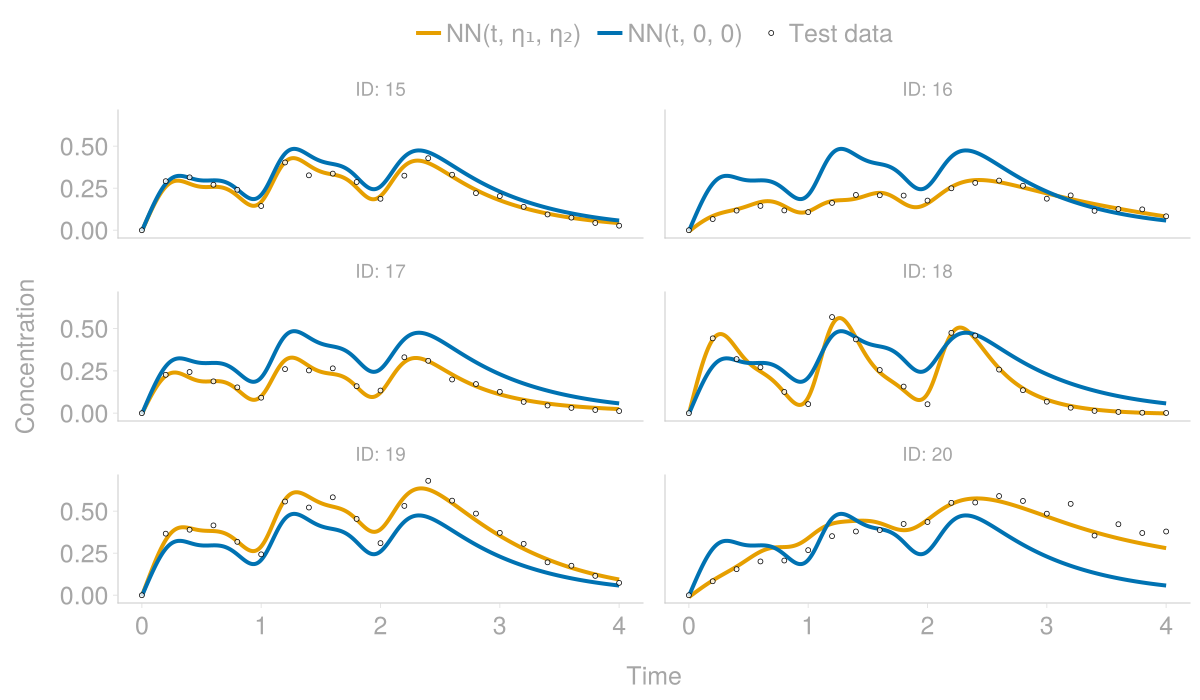

In [32]:
#| fig-cap: "&nbsp;"

pred = predict(fpm, pop_nodose[15:end]; obstimes=0:0.01:4)
fig = plotgrid(pred; ipred=(; label="NN(t, η₁, η₂)"), pred=(; label="NN(t, 0, 0)"), data=(; label="Test data"), figure)

## Mixed effect neural networks 

Pharmacometricians view:

- Random effects enables [individualization]{.att}
- Captures [between-subject variability]{.att}

Data scientists view:

- Random effects are ["latent variables"]{.att}
- Longitudinal [feature extraction]{.att}
- The NLME model is both and [encoder]{.att} and a [decoder]{.att} of random effects



# Deep nonlinear mixed effect models (DeepNLME)

## DeepNLME


$$
\begin{aligned}
\frac{dDepot}{dt} &= - K_a \cdot Depot\\
\frac{dCentral}{dt} &= K_a \cdot Depot - CL/V_c \cdot Central\\
\frac{dR}{dt} &= k_{in} \cdot (1 + {\color{orange} NN}({\color{orange} Central}, {\color{orange}η_1}, {\color{orange}η_2})) - k_{out} \cdot R
\end{aligned}
$$

[Link to tutorial](https://laughing-barnacle-p8o35eq.pages.github.io/demos/01-DeepPumas_basics.html)


# Random effects and covariate modelling

## Powerful model augmentation
![&nbsp;](image-11.png)

- Extract [posterior]{.att} random effects, [$η^*$]{.att}, from NLME model
- Train Machine learing mapping [covariates $\to$ $η^*$]{.att}
- [Embed]{.att} trained machine learning in NLME model

&nbsp;

- Flexible
- Collaborative

## Complex covariates
![&nbsp;](image-12.png)
[Link to tutorial](https://laughing-barnacle-p8o35eq.pages.github.io/demos/02-image_covariates.html)

# Epidemiological example use-case

##

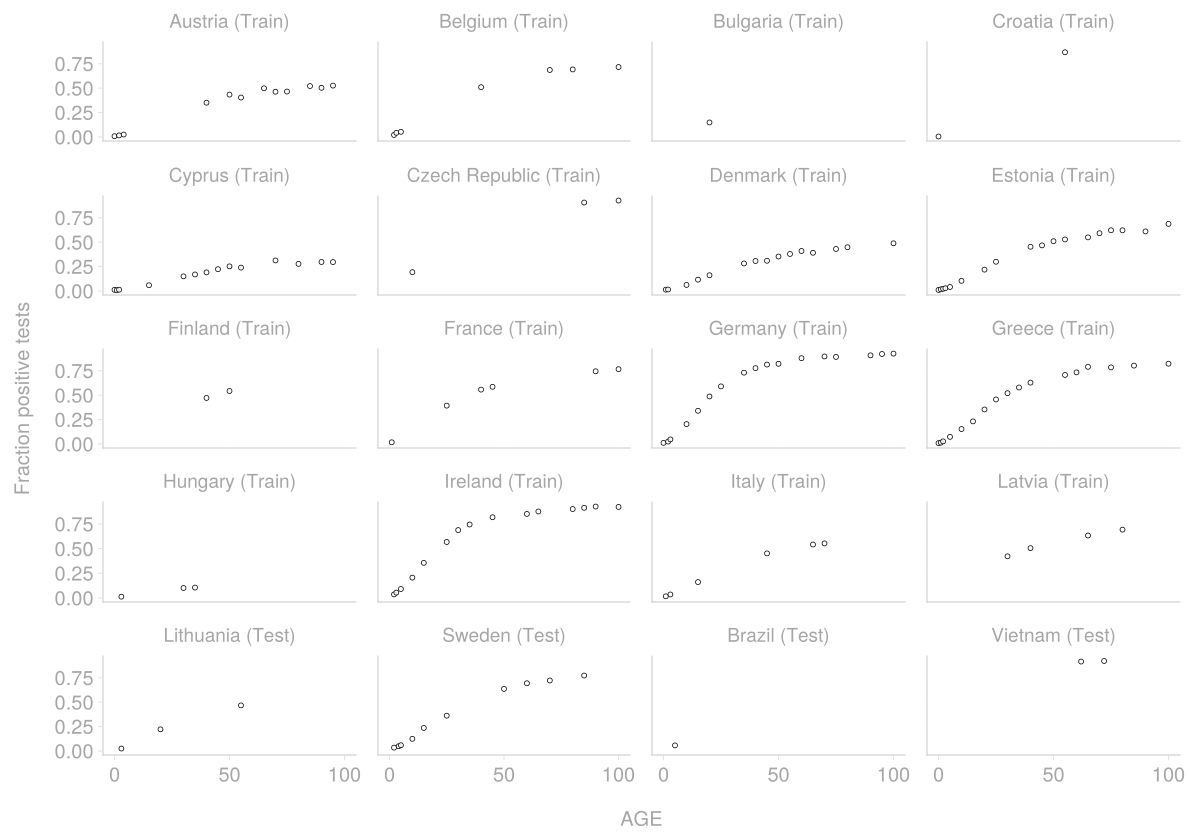

In [33]:
#| fig-cap: "&nbsp;"

t = 0:0.1:100
λ(t) = pdf.(Normal(16, 7),t) .+ 1.2.*pdf.(Normal(37, 10), t) .+ 0.4 .* pdf.(Normal(65, 14), t) .+ 0.02
fig = lines(t, λ)
ylims!(0, nothing)
fig

epi_data_model = @model begin
  @param begin
    σ ∈ RealDomain(; lower=0, init=10)
    tvc ∈ RealDomain(; lower=0)
    ω ∈ RealDomain(; lower=0)
  end
  @random η ~ Normal(0, ω)
  @pre begin
    c = tvc * exp(η)
    _λ = t -> c * λ(t)
  end
  @init S = 1
  @dynamics begin
    S' = - _λ(t) * S
  end
  @derived begin
    "Positive test fraction"
    PosFrac ~ @. Beta(σ*(1-0.99S), σ*(0.99S))
  end
end


countries = ["Austria", "Belgium", "Bulgaria", "Croatia", "Cyprus", "Czech Republic", "Denmark", "Estonia", "Finland", "France", "Germany", "Greece", "Hungary", "Ireland", "Italy", "Latvia", "Lithuania", "Sweden"]

p_epi = (; tvc=0.3, σ=1000., ω=0.6)
obstimes=vcat(0:5,10:5:100)
rng = StableRNG(123)
sim = map(eachindex(countries)) do i
  simobs(
    epi_data_model,
    Subject(; id=countries[i]),
    p_epi;
    rng,
    obstimes = sort(sample(rng, obstimes, rand(rng, 1:20); replace=false))
  )
end
pop_epi_good = Subject.(sim)


sparse_countries = ["Brazil", "Vietnam"]
sim_sparse = map(eachindex(sparse_countries)) do i
  simobs(
    epi_data_model,
    Subject(; id=sparse_countries[i]),
    p_epi;
    obstimes = sort(sample(rng, 1:100, rand(rng, 1:2); replace=false)),
    rng
  )
end

sims = vcat(sim, sim_sparse)
pop_epi = Subject.(sims)

tpop_epi = pop_epi[1:end-4]
vpop_epi = pop_epi[end-3:end]

plotgrid(
  pop_epi; 
  xlabel="AGE",
  ylabel="Fraction positive tests",
  figure = (; fontsize=20, resolution=0.7 .* (1700, 1200)),
  legend=false,
  data = (; markerwidth=10),
  axis = (; yticks=0:0.25:1),
  title = (s, i) -> "$(s.id) ($(s.id in getfield.(vpop_epi, :id) ? "Test" : "Train"))"
)



## 

In [34]:
#| echo: true
#| output: false
epi_model = @model begin
  @param begin
    N ∈ RealDomain(; lower=0, init=1000)
    λ ∈ MLPDomain(2, 5, 5, (1, softplus); reg=L2(1e-2))
  end
  @random η ~ Normal(0, 0.1)
  @init S = 1
  @dynamics S' = - λ(t/100, η)[1] * S
  @derived PosFrac ~ @. Beta(abs(N*(1-0.99S)), abs(N*(0.99S)))
end

PumasModel
  Parameters: N, λ
  Random effects: η
  Covariates: 
  Dynamical system variables: S
  Dynamical system type: Nonlinear ODE
  Derived: PosFrac
  Observed: PosFrac

- Data-driven discovery of force-of-infection, $\lambda(Age)$.
- $\lambda$, is shared but tunable with a single degree of freedom across countries.

In [35]:
#| output: false
#| warning: false
fpm_epi = @cache fit(
  epi_model,
  tpop_epi,
  init_params(epi_model),
  MAP(LaplaceI());
  checkidentification=false,
  optim_options = (; time_limit=5*60)
)

┌ Info: Checking the initial parameter values.
└ @ Pumas /Users/niklas/.julia/packages/Pumas/PkWZl/src/estimation/likelihoods.jl:4092
┌ Info: The initial negative log likelihood and its gradient are finite. Check passed.
└ @ Pumas /Users/niklas/.julia/packages/Pumas/PkWZl/src/estimation/likelihoods.jl:4111


Iter     Function value   Gradient norm 
     0     1.491244e+05     1.467690e+05
 * time: 9.918212890625e-5
     1     5.203180e+04     4.981180e+04
 * time: 0.1375110149383545
     2     2.953902e+04     2.765492e+04
 * time: 0.27370500564575195
     3     1.371363e+04     1.201996e+04
 * time: 0.40894007682800293
     4     7.870065e+03     6.449473e+03
 * time: 0.5355501174926758
     5     4.117218e+03     2.969183e+03
 * time: 0.6578621864318848
     6     2.320042e+03     1.550469e+03
 * time: 0.7563810348510742
     7     1.349228e+03     1.113679e+03
 * time: 0.8462061882019043
     8     8.423035e+02     8.071288e+02
 * time: 0.9234981536865234
     9     5.794752e+02     5.800430e+02
 * time: 0.986868143081665
    10     4.579182e+02     4.164901e+02
 * time: 1.040478229522705
    11     4.142961e+02     3.114663e+02
 * time: 1.08787202835083
    12     4.031752e+02     2.569911e+02
 * time: 1.1340601444244385
    13     3.992080e+02     2.312676e+02
 * time: 1.1792340278625

FittedPumasModel

Successful minimization:                     false

Likelihood approximation:           MAP (LaplaceI)
Likelihood Optimizer:                         BFGS
Dynamical system type:               Nonlinear ODE
Solver(s):                          (Vern7,Rodas5)

Log-likelihood value:                    259.73384
Number of subjects:                             16
Number of parameters:         Fixed      Optimized
                                  0             52
Observation records:         Active        Missing
    PosFrac:                    142              0
    Total:                      142              0

----------------------------
                  Estimate
----------------------------
N               1297.8
λ_layer₁_w₁,₁      0.11043
λ_layer₁_w₂,₁     -5.0423
λ_layer₁_w₃,₁      1.0932
λ_layer₁_w₄,₁      1.2228
λ_layer₁_w₅,₁      1.2641
λ_layer₁_w₁,₂      0.97016
λ_layer₁_w₂,₂      0.29217
λ_layer₁_w₃,₂      0.24063
λ_layer₁_w₄,₂      0.064462
λ_layer₁_w₅,₂      

##

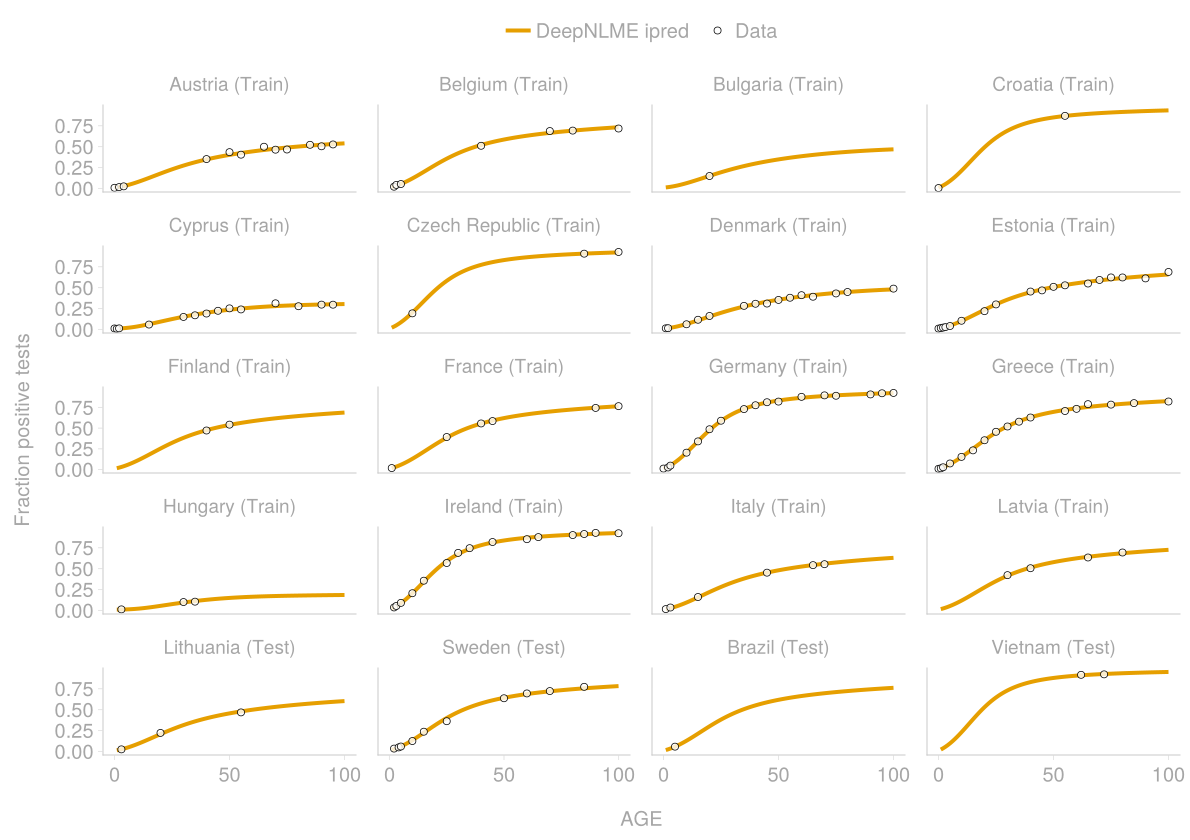

In [36]:
#| fig-cap: "&nbsp;"
plt_epi = plotgrid(
  predict(fpm_epi, pop_epi; obstimes=1:100); 
  xlabel="AGE",
  ylabel="Fraction positive tests",
  figure = (; fontsize=20, resolution=0.7 .* (1700, 1200)),
  # legend=false,
  data = (; markersize=10),
  axis = (; yticks=0:0.25:1),
  title = (s, i) -> "$(s.id) ($(s.id in getfield.(vpop_epi, :id) ? "Test" : "Train"))",
  ipred = (; label="DeepNLME ipred"),
  pred=false,
)

##

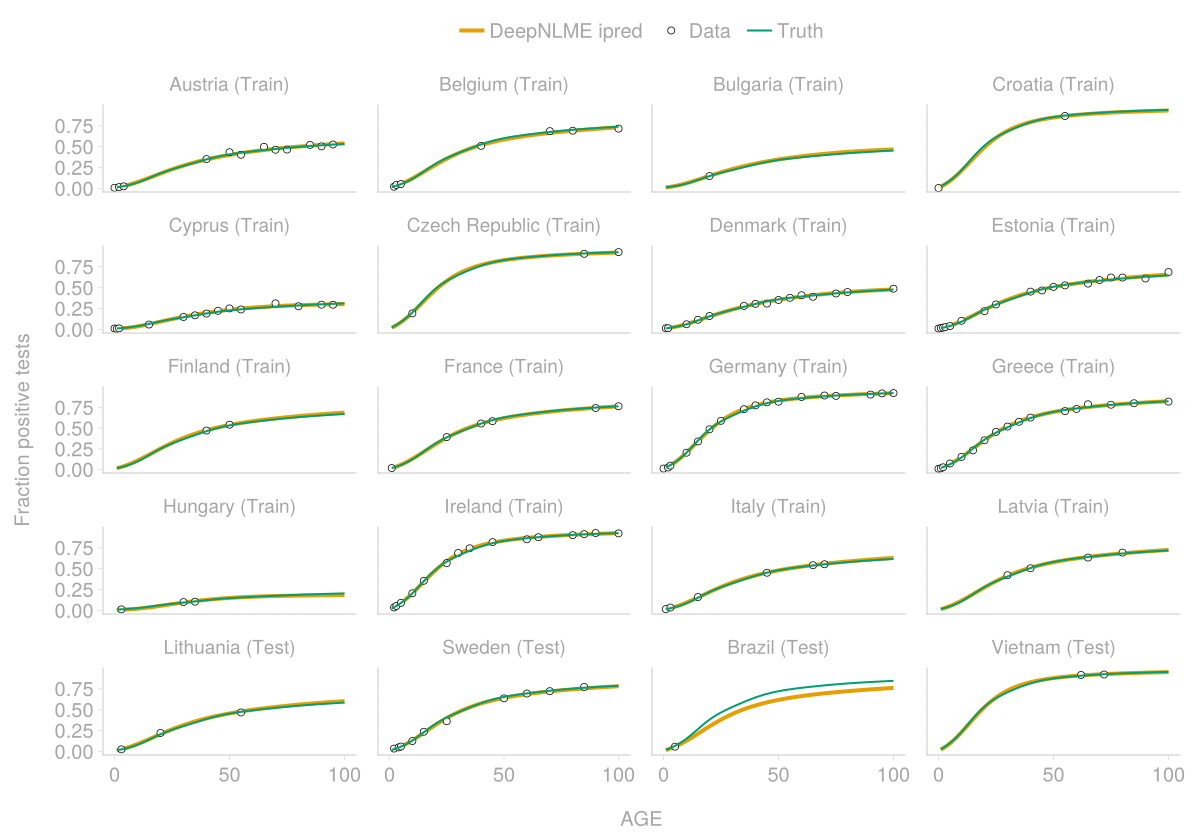

In [37]:
#| fig-cap: "&nbsp;"
plotgrid!(
  simobs(epi_data_model, pop_epi, p_epi, getfield.(sims, :randeffs); simulate_error=false, obstimes=1:100); 
  xlabel="AGE",
  ylabel="Fraction positive tests",
  title = (s, i) -> "$(s.id) ($(s.id in getfield.(vpop_epi, :id) ? "Test" : "Train"))",
  sim = (; linestyle=:solid, markersize=0, linewidth=2, label="Truth")
)

## 

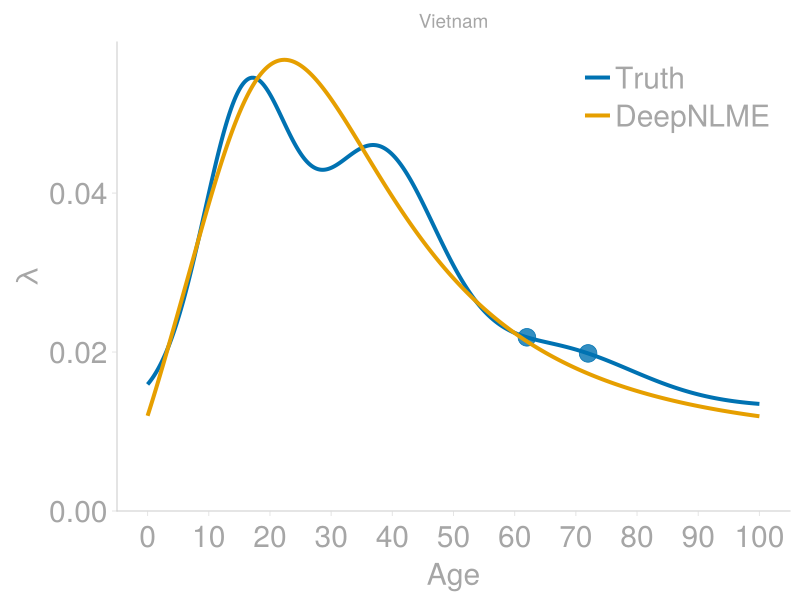

In [38]:
#| fig-cap: "&nbsp;"
country_id=20
nn = coef(fpm_epi).λ
η = empirical_bayes(fpm_epi, pop_epi[country_id]).η
inn = t -> nn(t/100, η)[1]
iλ = sims[country_id].icoefs._λ[1]
fig = Figure(; fontsize=30)
ax = Axis(fig[1,1], xlabel="Age", ylabel="λ", xticks=0:10:100, title=vcat(countries, sparse_countries)[country_id])
data_times = sims[country_id].time

lines!(ax, t, iλ; label="Truth")
scatter!(ax, data_times, iλ; markersize=25)
lines!(ax, t, inn; label="DeepNLME")
ylims!(ax, 0, nothing)
axislegend(ax)
fig

## What did this do?


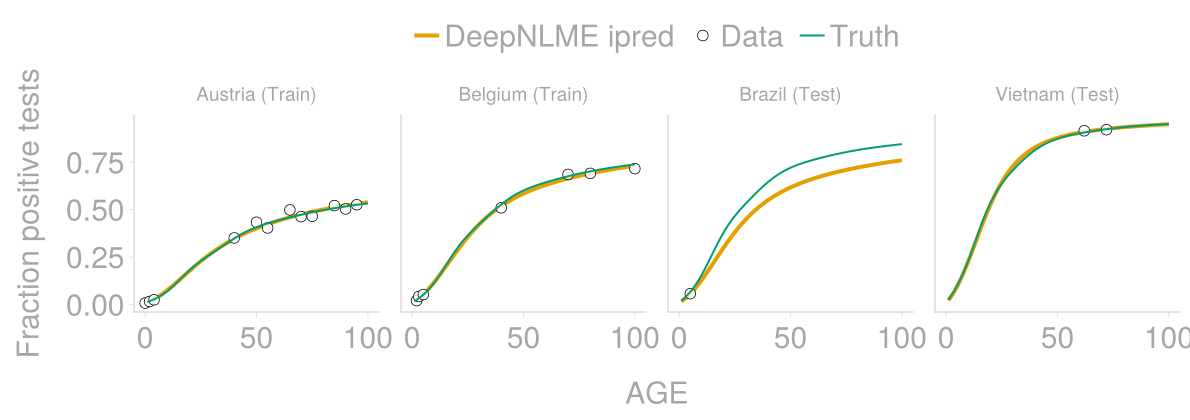

In [39]:
ids = [1,2,19,20]
plotgrid(
  predict(fpm_epi, pop_epi[ids]; obstimes=1:100); 
  xlabel="AGE",
  ylabel="Fraction positive tests",
  figure = (; fontsize=30, resolution=0.7 .* (1700, 600)),
  # legend=false,
  data = (; markersize=15),
  axis = (; yticks=0:0.25:1),
  layout = (4,1),
  title = (s, i) -> "$(s.id) ($(s.id in getfield.(vpop_epi, :id) ? "Test" : "Train"))",
  ipred = (; label="DeepNLME ipred"),
  pred=false,
)
plotgrid!(
  simobs(epi_data_model, pop_epi[ids], p_epi, getfield.(sims[ids], :randeffs); simulate_error=false, obstimes=1:100); 
  xlabel="AGE",
  ylabel="Fraction positive tests",
  title = (s, i) -> "$(s.id) ($(s.id in getfield.(vpop_epi, :id) ? "Test" : "Train"))",
  sim = (; linestyle=:solid, markersize=0, linewidth=2, label="Truth")
)


- Disentangled differences from comonalities
- Enabled appropriate use of data of different quality
- Accurate predictions for countries with little data


# Conclusion

## DeepNLME

:::: {.columns}
::: {.column width="60%"}

![](image-7.png){width="100%"}
:::

::: {.column width="40%"}

- Smooth timecourses
- Mechanisms
- Separation of variability
- Encoder / Decoder
- Complex data
- Collaborative!
:::
::::

## DeepNLME

Utilize *more* information

- Domain specific knowledge
- Complex data
- Hieriarcihally structured data


## Deeper dives

Two-day workshops this year 

- PAGE

- ACoP (tentative)

## Any last questions?

## Thanks for attending!